In [18]:
import pandas as pd
import re
import textCleaning as tc
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sklearn.metrics import mean_squared_error
from LR import Model

In [19]:
df = pd.read_csv("data/tiktok_comments_with_sentiment.csv")
df

,text,createTime,sentiment_score,sentiment_label
0,gibran:,1764933105,-0.014373,neutral
1,ini emg harusnya ganti rakyat sih. bgnian emg ...,1764928295,0.994941,positive
2,wapres aja gak pakek rompi anti peluru,1764922201,0.035081,neutral
3,di indo doang presiden n wapres di hujat wkwk,1764925978,-0.009545,neutral
4,"di X parah bett anjir komenannya, merinding la...",1764922173,0.911693,positive
...,...,...,...,...
4140,dy emg bnr2 idola emak2 indonesia (bahagia)\r\...,1764986048,0.990931,positive
4141,sip saya catat,1764985783,0.964800,positive
4142,"serba salah banget, keliatan dikata pencitraan...",1764985734,0.978314,positive
4143,"mas wapres panen pahala dari para hatter,\r\ns...",1764985669,0.994848,positive


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4145 entries, 0 to 4144
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             4145 non-null   object 
 1   createTime       4145 non-null   int64  
 2   sentiment_score  4145 non-null   float64
 3   sentiment_label  4145 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 129.7+ KB


In [21]:
df.dropna(inplace=True, subset=['text', 'createTime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4145 entries, 0 to 4144
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             4145 non-null   object 
 1   createTime       4145 non-null   int64  
 2   sentiment_score  4145 non-null   float64
 3   sentiment_label  4145 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 129.7+ KB


#### WordCloud

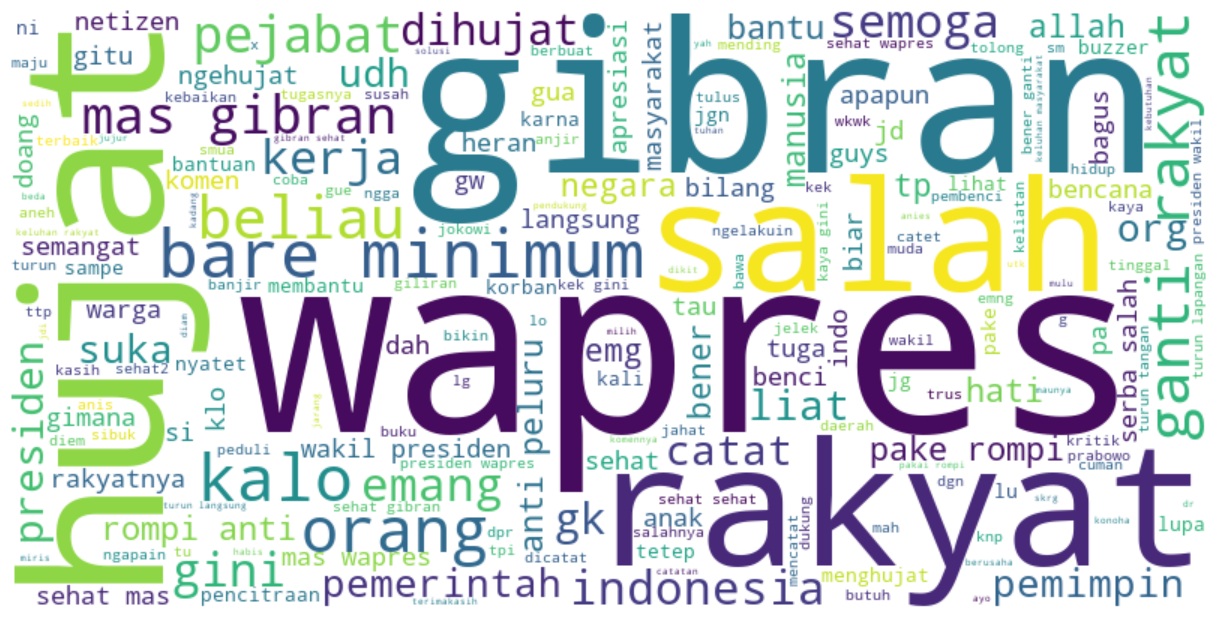

In [22]:
from wordcloud import WordCloud

def clean_text_for_indobert(text):
    text = text.lower()
    # remove content inside parentheses (so words in (...) are excluded)
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleanedTxt = df['text'].apply(clean_text_for_indobert)
wordcloudtxt = cleanedTxt.apply(tc.tokenizingText).apply(tc.filteringText)
    
# Convert list of tokens back to string
wordcloud_text = ' '.join(wordcloudtxt.apply(lambda x: ' '.join(x)))

# Create wordcloud from cleaned text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)

# Display wordcloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


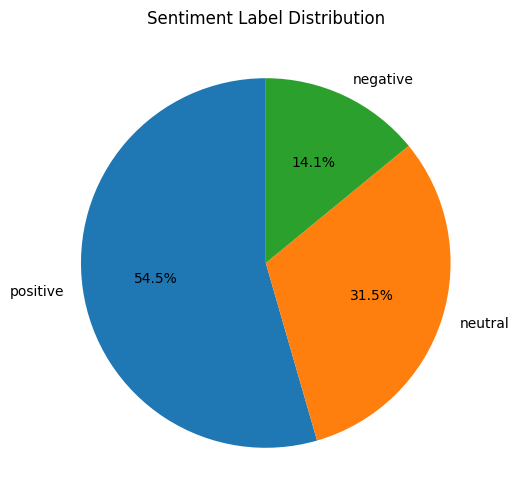

In [23]:
# Count sentiment labels
sentiment_counts = df['sentiment_label'].value_counts()

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Sentiment Label Distribution")
plt.show()

In [24]:
x = pd.to_datetime(df['createTime'], unit='s')

df_regression = pd.DataFrame()
start_time = x.min()

df_regression['x'] = (x - start_time).dt.total_seconds() / 3600
df_regression['y'] = df['sentiment_score']


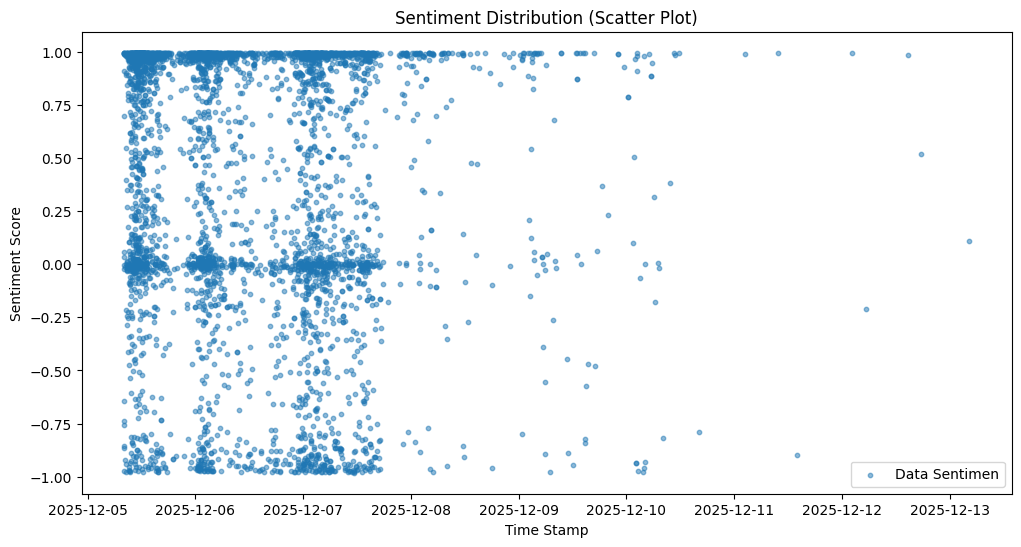

In [25]:
# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(x, df['sentiment_score'], alpha=0.5, s=10, label='Data Sentimen')
plt.title("Sentiment Distribution (Scatter Plot)")
plt.xlabel("Time Stamp" )
plt.ylabel("Sentiment Score")
plt.legend()
plt.show()

In [26]:
def get_quantile_knots(x_data, n_knots):
    percentiles = np.linspace(0, 100, n_knots + 2)[1:-1]
    knots = np.percentile(x_data, percentiles)
    return knots

def create_spline_features(x_data, knots):
    N = len(x_data)
    X_matrix = x_data.reshape(-1, 1)
    
    for k in knots:
        spline_col = np.maximum(0, x_data - k).reshape(-1, 1)
        X_matrix = np.hstack([X_matrix, spline_col])
        
    return X_matrix

def calculate_gcv(y_true, y_pred, n_knots):
    n = len(y_true)
    df = 1 + 1 + n_knots  # Intercept + Slope + Knots
    mse = np.mean((y_true - y_pred)**2)
    # Proteksi pembagian nol
    if (1 - df/n) <= 0: return float('inf') 
    penalty = (1 - (df / n)) ** 2
    return mse / penalty

def auto_tune_spline(x_data, y_data, max_knots=10):
    best_n = 1
    best_score = float('inf')
    
    # Kita simpan "artefak" terbaiknya di sini
    best_model_obj = None
    best_knots_loc = None
    

    for n in range(1, max_knots + 1):
        # A. Setup
        current_knots = get_quantile_knots(x_data, n)
        X_spline = create_spline_features(x_data, current_knots)
        
        # B. Train
        model = Model()
        model.fit(X_spline, y_data)
        y_pred = model.predict(X_spline)
        
        # C. Score
        score = calculate_gcv(y_data, y_pred, n)
        
        if score < best_score:
            best_score = score
            best_n = n
            
            # SIMPAN OBJEK PENTINGNYA
            best_model_obj = model
            best_knots_loc = current_knots
        

    return best_n, best_knots_loc, best_model_obj

In [27]:
x=df_regression['x'].values
y=df_regression['y'].values
n_knots = 10
optimal_n, final_knots, final_model = auto_tune_spline(x, y, n_knots)
print(f"Lokasi Knots ditemukan di x = {final_knots}")
X_spline = create_spline_features(x, final_knots)

Lokasi Knots ditemukan di x = [ 2.75788889  4.73433333 11.52788889 18.02261111 23.04722222 37.68755556
 41.64822222 45.61644444 53.38861111]


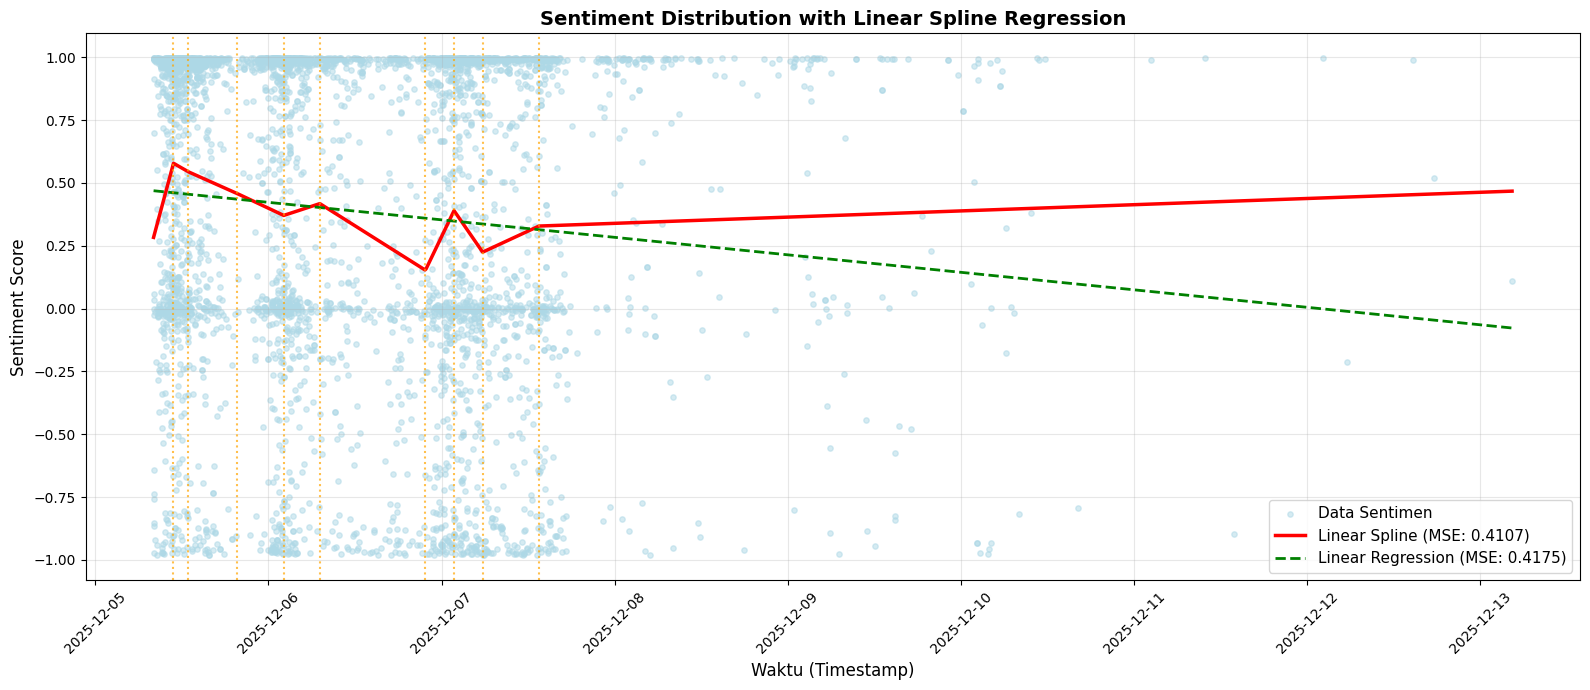


=== Lokasi Knot (Waktu Sebenarnya) ===
Knot 1: x=2.76 jam → 2025-12-05 10:49:48
Knot 2: x=4.73 jam → 2025-12-05 12:48:23
Knot 3: x=11.53 jam → 2025-12-05 19:36:00
Knot 4: x=18.02 jam → 2025-12-06 02:05:41
Knot 5: x=23.05 jam → 2025-12-06 07:07:09
Knot 6: x=37.69 jam → 2025-12-06 21:45:35
Knot 7: x=41.65 jam → 2025-12-07 01:43:13
Knot 8: x=45.62 jam → 2025-12-07 05:41:19
Knot 9: x=53.39 jam → 2025-12-07 13:27:38


In [28]:
final_model.fit(X_spline, y)
y_pred = final_model.predict(X_spline)

model_no_spline = Model()
model_no_spline.fit(x.reshape(-1, 1), y)
y_pred_linear = model_no_spline.predict(x.reshape(-1, 1))

# Calculate MSE
mse_spline = mean_squared_error(y, y_pred)
mse_linear = mean_squared_error(y, y_pred_linear)

# Konversi x (jam) kembali ke timestamp asli
x_timestamps = start_time + pd.to_timedelta(x, unit='h')

# --- PERBAIKAN DI SINI ---
# Dapatkan index yang membuat x_timestamps menjadi urut
sorted_indices = np.argsort(x_timestamps)

# Urutkan sumbu X dan hasil prediksi (y_pred) berdasarkan index tersebut
x_sorted = x_timestamps[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

# Lakukan hal yang sama untuk Linear Regression agar rapi (opsional jika sudah lurus)
y_pred_linear_sorted = y_pred_linear[sorted_indices]

# Konversi posisi knot ke timestamp (tidak perlu sort karena biasanya knot sudah urut)
knot_timestamps = start_time + pd.to_timedelta(final_knots, unit='h')

plt.figure(figsize=(16, 7))

# Scatter plot TIDAK perlu di-sort (karena titik berdiri sendiri), tapi agar konsisten boleh saja
plt.scatter(x_timestamps, y, alpha=0.5, s=15, label='Data Sentimen', color='lightblue')

# Plot garis menggunakan data yang SUDAH DIURUTKAN
plt.plot(x_sorted, y_pred_sorted, color='red', linewidth=2.5, label=f'Linear Spline (MSE: {mse_spline:.4f})')
plt.plot(x_sorted, y_pred_linear_sorted, color='green', linewidth=2, linestyle='--', label=f'Linear Regression (MSE: {mse_linear:.4f})')

# Tampilkan hanya setiap knot ke-n untuk menghindari overcrowding
step = max(1, len(final_knots) // 10)  # Tampilkan maksimal 10 knot
for i, knot_time in enumerate(knot_timestamps):
    if i % step == 0:
        plt.axvline(knot_time, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)

plt.title("Sentiment Distribution with Linear Spline Regression", fontsize=14, fontweight='bold')
plt.xlabel("Waktu (Timestamp)", fontsize=12)
plt.ylabel("Sentiment Score", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print knot timestamps
print(f"\n=== Lokasi Knot (Waktu Sebenarnya) ===")
for i, (knot_x, knot_time) in enumerate(zip(final_knots, knot_timestamps), 1):
    print(f"Knot {i}: x={knot_x:.2f} jam → {knot_time.strftime('%Y-%m-%d %H:%M:%S')}")


In [29]:
h = 1
df_regression_indexed = df_regression.set_index(pd.to_datetime(df['createTime'], unit='s'))

df_resampled = df_regression_indexed['y'].resample(f'{h}h').mean()
df_resampled = df_resampled.dropna()

start_time = df_resampled.index.min()
df_regression_resampled = pd.DataFrame()
df_regression_resampled['x'] = (df_resampled.index - start_time).total_seconds() / 3600
df_regression_resampled['y'] = df_resampled.values

In [30]:
x = df_regression_resampled['x'].values
y = df_regression_resampled['y'].values
n_knots = 100
optimal_n, final_knots, final_model = auto_tune_spline(x, y, n_knots)
print(f"Lokasi Knots ditemukan di x = {final_knots}")
X_spline = create_spline_features(x, final_knots)

Lokasi Knots ditemukan di x = [ 25.8  51.6  77.4 104.2]


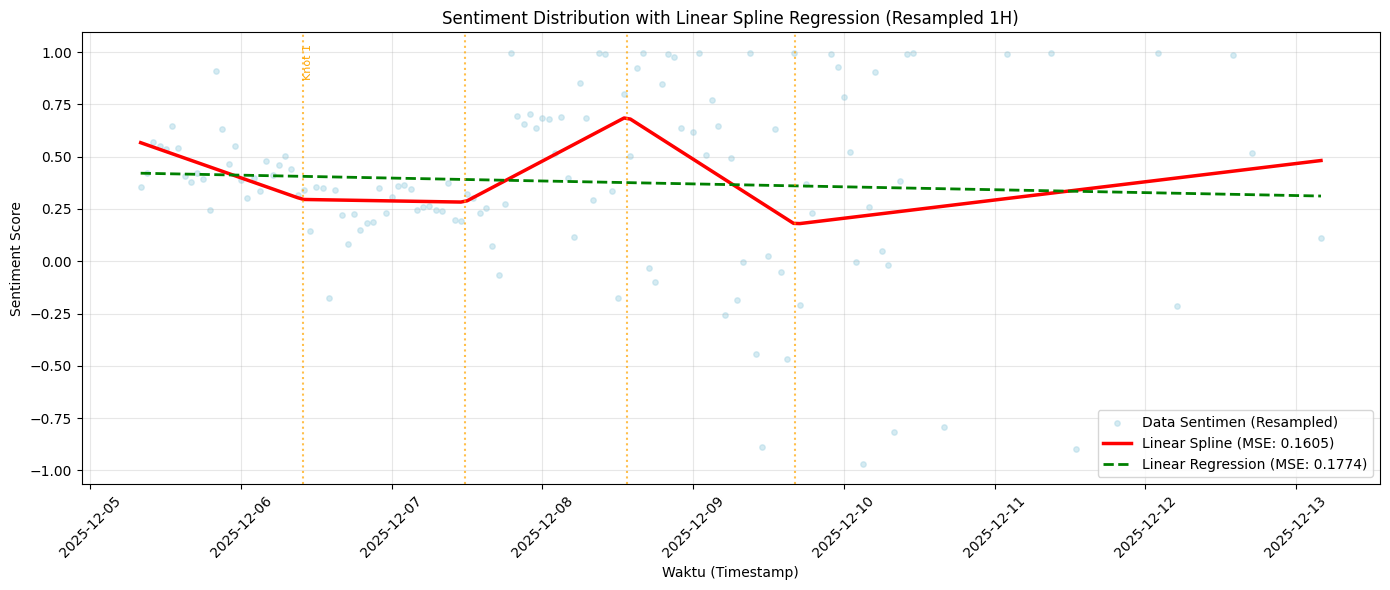


=== Lokasi Knot (Waktu Sebenarnya) ===
Knot 1: x=25.80 jam → 2025-12-06 09:48:00
Knot 2: x=51.60 jam → 2025-12-07 11:36:00
Knot 3: x=77.40 jam → 2025-12-08 13:24:00
Knot 4: x=104.20 jam → 2025-12-09 16:12:00


In [31]:
final_model = Model()
final_model.fit(X_spline, y)
y_pred = final_model.predict(X_spline)

model_no_spline = Model()
model_no_spline.fit(x.reshape(-1, 1), y)
y_pred_linear = model_no_spline.predict(x.reshape(-1, 1))

# Calculate MSE
mse_spline = mean_squared_error(y, y_pred)
mse_linear = mean_squared_error(y, y_pred_linear)

# Konversi x (jam) kembali ke timestamp asli
x_timestamps = start_time + pd.to_timedelta(x, unit='h')

# Konversi posisi knot ke timestamp
knot_timestamps = start_time + pd.to_timedelta(final_knots, unit='h')

plt.figure(figsize=(14, 6))
plt.scatter(x_timestamps, y, alpha=0.5, s=15, label='Data Sentimen (Resampled)', color='lightblue')
plt.plot(x_timestamps, y_pred, color='red', linewidth=2.5, label=f'Linear Spline (MSE: {mse_spline:.4f})')
plt.plot(x_timestamps, y_pred_linear, color='green', linewidth=2, linestyle='--', label=f'Linear Regression (MSE: {mse_linear:.4f})')

# Tambahkan garis vertikal untuk knot positions
for i, knot_time in enumerate(knot_timestamps):
    plt.axvline(knot_time, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
    if i == 0:
        plt.text(knot_time, plt.ylim()[1] * 0.95, f'Knot {i+1}', 
                 rotation=90, verticalalignment='top', fontsize=8, color='orange')

plt.title(f"Sentiment Distribution with Linear Spline Regression (Resampled {h}H)")
plt.xlabel("Waktu (Timestamp)")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print knot timestamps
print(f"\n=== Lokasi Knot (Waktu Sebenarnya) ===")
for i, (knot_x, knot_time) in enumerate(zip(final_knots, knot_timestamps), 1):
    print(f"Knot {i}: x={knot_x:.2f} jam → {knot_time.strftime('%Y-%m-%d %H:%M:%S')}")

In [32]:
class PositivePart(sp.Function):
    def _sympystr(self, printer):
        arg = printer._print(self.args[0])
        return f"({arg})₊"

    def _latex(self, printer):
        arg = printer._print(self.args[0])
        # Format LaTeX resmi: ( ... )_+
        return r"\left( " + arg + r" \right)_+"

    @classmethod
    def eval(cls, arg):
        if arg.is_Number:
            return sp.Max(0, arg)
    
def spline_sympy(intercept, coefs, knots):
    x = sp.Symbol('x')
    
    equation = sp.Float(intercept, 3) + sp.Float(coefs[0], 3) * x
    
    for k, coef in zip(knots, coefs[1:]):
        term = sp.Float(coef, 3) * PositivePart(x - sp.Float(k, 3))        
        equation += term

    
    return sp.Eq(sp.Symbol('y'), equation)

# Ambil intercept dan koefisien
b0 = final_model.intercept_
b = final_model.coef_

# Format string
eq_str = f"y = {b0:.3f}"
eq_str += f" + {b[0]:.3f}x" # Slope awal

for i, (k, coef) in enumerate(zip(final_knots, b[1:])):
    sign = "+" if coef >= 0 else "" # Biar rapi plus minusnya
    eq_str += f" {sign} {coef:.3f}(x - {k:.1f})+"

spline_sympy(b0, b, final_knots)

Eq(y, -0.0105*x + 0.0228*(x - 104.0)₊ - 0.035*(x - 77.4)₊ + 0.0163*(x - 51.6)₊ + 0.01*(x - 25.8)₊ + 0.567)

In [33]:
improvement = ((mse_linear - mse_spline) / mse_linear) * 100
print(f"Metode Spline Truncated berhasil menurunkan error sebesar {improvement:.2f}% dibandingkan Regresi Linear biasa.")

Metode Spline Truncated berhasil menurunkan error sebesar 9.56% dibandingkan Regresi Linear biasa.


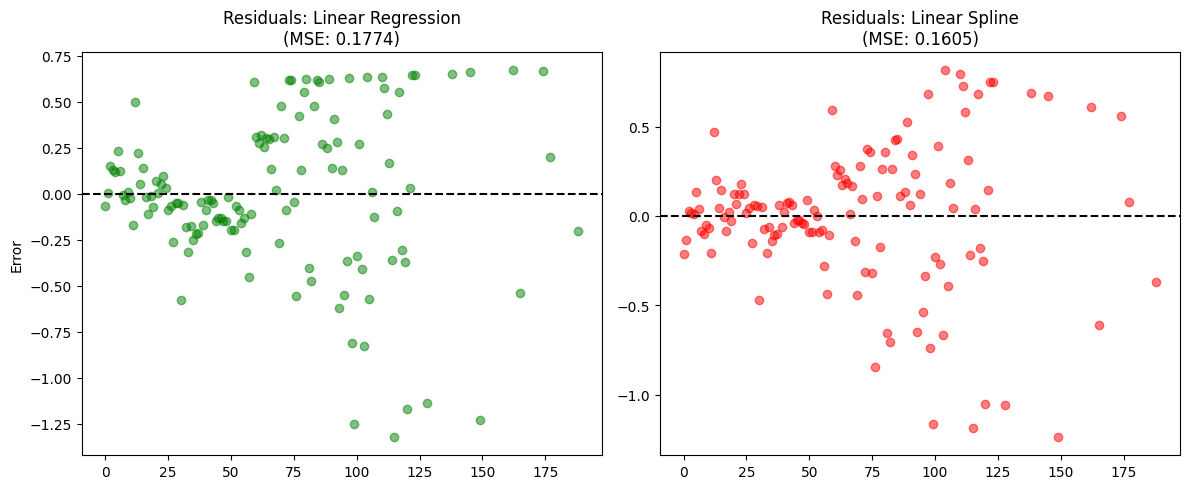

In [34]:
residuals_linear = y - y_pred_linear
residuals_spline = y - y_pred

plt.figure(figsize=(12, 5))

# Plot Residual Linear (Merah - Biasanya Polanya Jelas)
plt.subplot(1, 2, 1)
plt.scatter(x, residuals_linear, color='green', alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title(f'Residuals: Linear Regression\n(MSE: {mse_linear:.4f})')
plt.ylabel('Error')
# Plot Residual Spline (Biru - Harusnya Lebih Acak/Kecil)
plt.subplot(1, 2, 2)
plt.scatter(x, residuals_spline, color='red', alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title(f'Residuals: Linear Spline\n(MSE: {mse_spline:.4f})')

plt.tight_layout()
plt.show()